In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# suppress warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
from fairness.modules import data_representation_fairness, risk_ratio_multilabel
from fairness.modules import coverage_gap_intersectional, risk_ratio_multilabel_intersectional_group
from fairness.modules import js_divergence_by_group, js_divergence_by_label_and_group

In [3]:
labels = [
    'Enlarged Cardiomediastinum',
    'Cardiomegaly',
    'Lung Opacity',
    'Lung Lesion',
    'Edema',
    'Consolidation',
    'Pneumonia',
    'Atelectasis',
    'Pneumothorax',
    'Pleural Effusion',
    'Pleural Other',
    'Fracture',
    'Support Devices',
    'No Finding'
]

labels_small = [
    'Cardiomegaly',
    'Pneumonia',
    'Pleural Effusion',
    'Fracture',
    'No Finding'
]

observations_abbr = {
    'Enlarged Cardiomediastinum': 'EC',
    'Cardiomegaly': 'Cd',
    'Lung Opacity': 'LO',
    'Lung Lesion': 'LL',
    'Edema': 'Ed',
    'Consolidation': 'Co',
    'Pneumonia': 'Pa',
    'Atelectasis': 'A',
    'Pneumothorax': 'Px',
    'Pleural Effusion': 'Ef',
    'Pleural Other': 'PO',
    'Fracture': 'Fr',
    'Support Devices': 'SD',
    'No Finding': 'NF'
}

results_path = './MT_files/'

train_file_path = "D:/chexpertchestxrays/train_visualCheXbert.csv"

balanced_train_file_path = "D:/chexpertchestxrays/CheXpert-v1.0/CheXpert-v1.0/train.csv"
test_file_path = "D:/chexpertchestxrays/CheXpert-v1.0/CheXpert-v1.0/valid.csv"


In [4]:
# Dataframes modifications

# Step 1. Outlier trimming, age disaggregation

def df_age_disaggregation(df, left_edge = 15, right_edge = 105, bin_width = 5):

    # define age bins and labels
    bins = list(range(left_edge, right_edge, bin_width)) 
    labels = [f"{b}–{b+4}" for b in bins[:-1]]

    if right_edge>105:
        bins.append(120)
        labels.append('>=100')
    
    df["age_group"]= pd.cut(
        df["Age"],
        bins=bins,
        labels=labels,
        right=False)
    
    return df

def df_preprocess(df):

    # this is a boolean filter for 'Unknown' value
    boolean_filter = df['Sex'] != 'Unknown'
    df = df.loc[boolean_filter].reset_index(drop=True)

    # this is a boolean filter for 0 value
    boolean_filter = df['Age'] != 0
    df = df.loc[boolean_filter].reset_index(drop=True)

    # this is a boolean filter for patients younger than 100 years
    boolean_filter = df['Age'] < 100
    df = df.loc[boolean_filter].reset_index(drop=True)

    # age disaggregation
    df = df_age_disaggregation(df)
    
    return df


# Step 2. Observation reduction
# Due to resource limitations, further analysis was focused on five pathologies: Cardiomegaly, Pneumonia, Pleural Effusion, Fracture, and No Finding.

def df_observation_reduction(df):

    df_changed = df
    
    boolean_filter = (
        (df_changed['Cardiomegaly'] == 1) |
        (df_changed['Pneumonia'] == 1) |
        (df_changed['Pleural Effusion'] == 1) |
        (df_changed['Fracture'] == 1) |
        (df_changed['No Finding'] == 1)
    )
    
    df_changed = df_changed.loc[boolean_filter].reset_index(drop=True)
    
    df_changed = df_changed.drop(['Enlarged Cardiomediastinum', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Atelectasis', 'Pneumothorax', 'Pleural Other', 'Support Devices'], axis=1)
    
    return df_changed

# Step 3. Data resampling, Males undersampling.
# This is a constrained combinatorial optimization problem (NP-hard).
# 50% Male / 50% Female in the whole dataframe, exactly
# For each disease column 50% Male / 50% Female, approximately

def build_balanced_df(df, labels, random_state=42):
    rng = np.random.default_rng(random_state)

    male_df = df[df['Sex'] == 'Male']
    female_df = df[df['Sex'] == 'Female']

    n = min(len(male_df), len(female_df))

    male_sample = male_df.sample(n, random_state=random_state)
    female_sample = female_df.sample(n, random_state=random_state)

    balanced = pd.concat([male_sample, female_sample]).sample(frac=1, random_state=random_state)

    def imbalance_score(d):
        score = 0
        for lab in labels:
            sub = d[d[lab] == 1]
            if len(sub) > 0:
                p = (sub['Sex'] == 'Male').mean()
                score += abs(p - 0.5)
        return score

    best = balanced.copy()
    best_score = imbalance_score(best)

    # try swaps
    for _ in range(1000):
        m = best[best['Sex'] == 'Male'].sample(1)
        f = best[best['Sex'] == 'Female'].sample(1)

        candidate = best.drop([m.index[0], f.index[0]])
        candidate = pd.concat([candidate, m.assign(Sex='Female'), f.assign(Sex='Male')])

        score = imbalance_score(candidate)
        if score < best_score:
            best = candidate
            best_score = score

    return best.reset_index(drop=True)

In [5]:
# Plots

def plot_age_distr_by_sex(df):
    fig, ax = plt.subplots(figsize=(10, 5))
    
    sns.histplot(
        df,
        x="Age", hue="Sex", 
        palette={'Male': 'cornflowerblue', 'Female': 'violet'},
        stat='probability',
        kde=True,
        ax=ax        
    )
    
    ax.set_xlabel('Age', fontsize=12, labelpad=10)
    ax.set_title('Sample distribution by age and sex', fontsize=14, color='black', fontweight='bold', pad=15)
    
    plt.tight_layout()
    fig.show()

def plot_agegroup_distr_by_sex(df, file_name = 'agegroup_distr_by_sex'):
    fig, ax = plt.subplots(figsize=(11, 5))

    df = df.sort_values(['age_group'])
    
    sns.histplot(
        df,
        x="age_group", hue="Sex", 
        palette={'Male': 'cornflowerblue', 'Female': 'violet'},
        stat='probability',
        kde=True,
        ax=ax
        
    )
    
    ax.set_xlabel('Age group', fontsize=12, labelpad=10)
    ax.set_title('Sample distribution by age group and sex', fontsize=14, color='black', fontweight='bold', pad=15)
    
    plt.tight_layout()
    plt.savefig(results_path+file_name+'.pdf', dpi=300, bbox_inches='tight')  # Save the plot
    fig.show()

def plot_pathologies_share_agegroup(df_pct, file_name='pathologies_share_agegroup'):

    colors = [
        "powderblue", "skyblue", 
        "palegreen", "lightgreen", "lawngreen", "limegreen", "mediumseagreen", "seagreen",
        "lightcoral", "indianred", "brown",
        "darkkhaki", "wheat", "lightgrey"
    ]
    
    fig, ax = plt.subplots(figsize=(18, 8))
    
    df_pct.plot(
        kind="bar",
        color=colors,
        stacked=True,
        ax=ax,
        width=0.9
    )
    
    ax.set_title("Relative Share of Pathologies Within Age Groups", 
                 color='black', fontfamily='sans-serif', fontweight='bold', fontsize=15, pad=15);
    
    ax.set_ylabel("Total observations (%)", fontsize=14)
    ax.set_xlabel("")
    ax.set_ylim(0, 100)
    
    ax.legend(
        title="Pathology",
        fontsize=14,
        bbox_to_anchor=(1.02, 1),
        loc="upper left"
    )
    
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.savefig(results_path+file_name+'.pdf', dpi=300, bbox_inches='tight')  # Save the plot
    plt.show()

def histogram_by_age(df, sex = 'Male', hue = "No Finding" ,file_name ='histogram_by_age'):

    if sex == 'Male':
        color = 'cornflowerblue'
    else:
        color = 'violet'
    
    fig, ax = plt.subplots(figsize=(6, 4))
    
    sns.histplot(x='Age', hue=hue, data=df, bins=50, palette={0: color, 1: 'grey'}, stat='probability',
                 kde=True, )

    title = hue + ': Sample Distribution by Age for '+ sex
    
    ax.set_title(title, 
                 color='black', fontfamily='sans-serif', fontweight='bold', fontsize=14, pad=15);
    ax.set_ylabel(" ");
    ax.set_xlabel("Age")

    # plt.savefig(results_path+file_name+'.pdf', dpi=300, bbox_inches='tight')  # Save the plot
    fig.show()

In [6]:

train_data = pd.read_csv(train_file_path)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223414 entries, 0 to 223413
Data columns (total 19 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Path                        223414 non-null  object 
 1   Sex                         223414 non-null  object 
 2   Age                         223414 non-null  int64  
 3   Frontal/Lateral             223414 non-null  object 
 4   AP/PA                       191027 non-null  object 
 5   Enlarged Cardiomediastinum  223414 non-null  float64
 6   Cardiomegaly                223414 non-null  float64
 7   Lung Opacity                223414 non-null  float64
 8   Lung Lesion                 223414 non-null  float64
 9   Edema                       223414 non-null  float64
 10  Consolidation               223414 non-null  float64
 11  Pneumonia                   223414 non-null  float64
 12  Atelectasis                 223414 non-null  float64
 13  Pneumothorax  

In [7]:
# train_data.columns = train_data.columns.str.lower()
train_data.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,No Finding
0,CheXpert-v1.0/train/patient00001/study1/view1_...,Female,68,Frontal,AP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,CheXpert-v1.0/train/patient00002/study2/view1_...,Female,87,Frontal,AP,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,CheXpert-v1.0/train/patient00002/study1/view1_...,Female,83,Frontal,AP,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
3,CheXpert-v1.0/train/patient00002/study1/view2_...,Female,83,Lateral,NaN,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
4,CheXpert-v1.0/train/patient00003/study1/view1_...,Male,41,Frontal,AP,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
train_data.describe()

,Age,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,No Finding
count,223414.000000,223414.000000,223414.000000,223414.000000,223414.000000,223414.000000,223414.000000,223414.000000,223414.000000,223414.000000,223414.000000,223414.000000,223414.000000,223414.000000,223414.000000
mean,60.527662,0.644409,0.545718,0.678118,0.138877,0.422400,0.479956,0.233763,0.554683,0.113417,0.463937,0.117831,0.276124,0.608556,0.159014
std,17.995927,0.478693,0.497907,0.467199,0.345819,0.493943,0.499599,0.423224,0.497002,0.317103,0.498699,0.322408,0.447080,0.488074,0.365690
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,49.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,62.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,74.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000
max,110.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [9]:
# There are no missing values
train_data.isna().sum(axis=0)

Path                              0
Sex                               0
Age                               0
Frontal/Lateral                   0
AP/PA                         32387
Enlarged Cardiomediastinum        0
Cardiomegaly                      0
Lung Opacity                      0
Lung Lesion                       0
Edema                             0
Consolidation                     0
Pneumonia                         0
Atelectasis                       0
Pneumothorax                      0
Pleural Effusion                  0
Pleural Other                     0
Fracture                          0
Support Devices                   0
No Finding                        0
dtype: int64

In [10]:
df_calc = train_data.groupby('Sex')[['Sex']].count()
print(df_calc)

            Sex
Sex            
Female    90777
Male     132636
Unknown       1


In [11]:
df_calc = train_data.groupby('Age')[['Age']].count()
print(df_calc)

      Age
Age      
0       3
18    766
19   1167
20   1287
21   1279
..    ...
106     7
107     2
108     3
109     1
110     4

[94 rows x 1 columns]


In [12]:
train_data = df_preprocess(train_data)

print(train_data.groupby('Sex')[['Sex']].count())

print(train_data[['Sex']].value_counts(normalize=True).to_frame())

print(train_data.groupby('Age')[['Age']].count())

print(train_data.groupby('age_group')[['age_group']].count())

           Sex
Sex           
Female   90607
Male    132573
        proportion
Sex               
Male      0.594018
Female    0.405982
      Age
Age      
18    766
19   1167
20   1287
21   1279
22   1370
..    ...
95    551
96    423
97    268
98    195
99    122

[82 rows x 1 columns]
           age_group
age_group           
15–19           1933
20–24           6553
25–29           6855
30–34           7271
35–39           8764
40–44          11085
45–49          14739
50–54          19406
55–59          24044
60–64          24561
65–69          24316
70–74          19430
75–79          18687
80–84          16407
85–89          11780
90–94           5790
95–99           1559


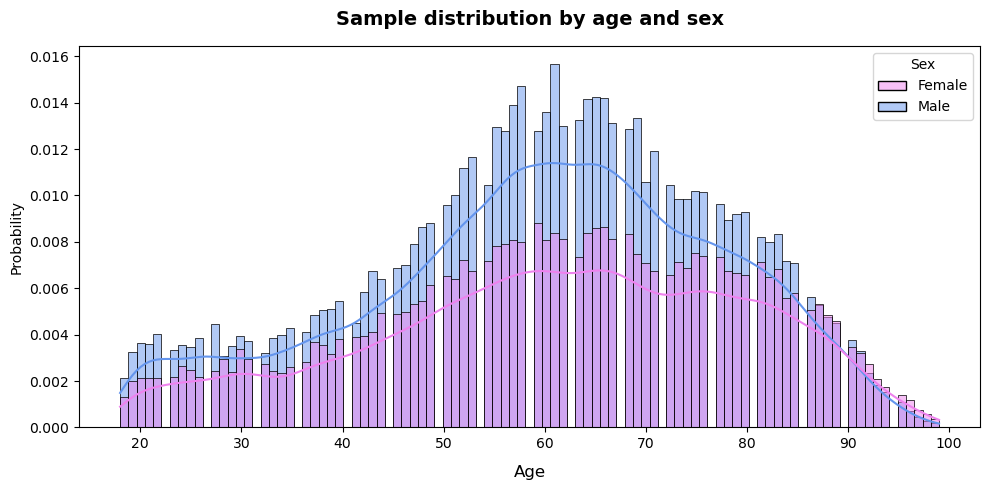

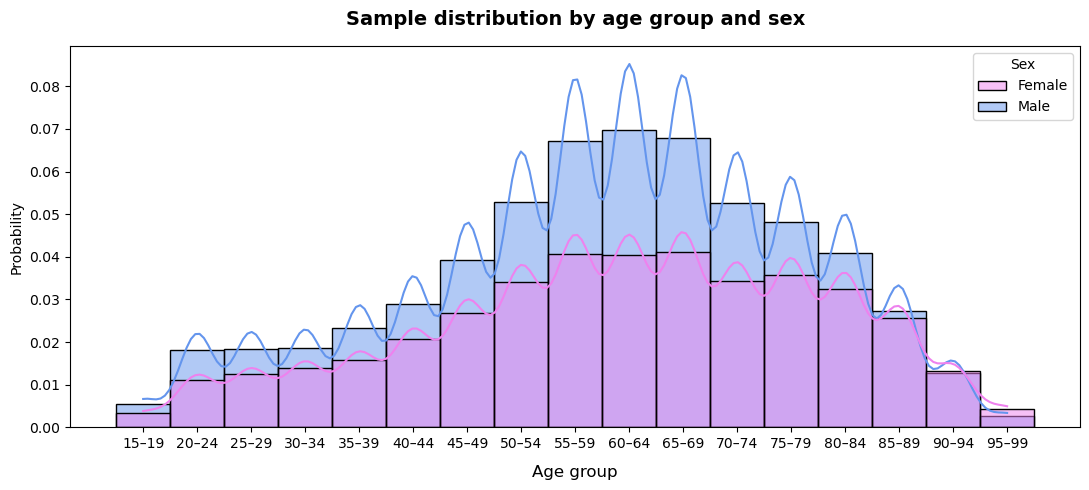

In [13]:
plot_age_distr_by_sex(train_data)

plot_agegroup_distr_by_sex(train_data, 'agegroup_distr_by_sex')

In [14]:
df_calc = train_data.groupby('age_group')[labels].sum()
df_calc

,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,No Finding
age_group,,,,,,,,,,,,,,
15–19,932.0,773.0,992.0,271.0,582.0,692.0,396.0,817.0,348.0,659.0,181.0,503.0,1146.0,526.0
20–24,2923.0,2277.0,3295.0,934.0,1751.0,2286.0,1332.0,2586.0,1148.0,2015.0,585.0,1595.0,3911.0,1751.0
25–29,3318.0,2548.0,3656.0,1155.0,2133.0,2592.0,1516.0,2760.0,1060.0,2204.0,608.0,1624.0,4085.0,1835.0
30–34,3624.0,2872.0,3912.0,1211.0,2310.0,2729.0,1575.0,2990.0,1039.0,2336.0,698.0,1674.0,4269.0,1941.0
35–39,4790.0,3936.0,5154.0,1324.0,3110.0,3472.0,1907.0,3987.0,1034.0,3214.0,824.0,2021.0,5236.0,2074.0
40–44,6267.0,5192.0,6739.0,1640.0,4082.0,4863.0,2503.0,5366.0,1287.0,4378.0,1100.0,2506.0,6914.0,2296.0
45–49,8712.0,7196.0,9287.0,1969.0,5566.0,6572.0,3192.0,7584.0,1590.0,6178.0,1535.0,3340.0,9150.0,2832.0
50–54,11850.0,9797.0,12628.0,2617.0,7603.0,8882.0,4385.0,10347.0,2305.0,8533.0,2100.0,4951.0,12195.0,3411.0
55–59,15311.0,12725.0,16352.0,3427.0,9801.0,11558.0,5750.0,13364.0,2989.0,11176.0,2777.0,6327.0,15499.0,3780.0


In [15]:
# column_totals = df_calc.sum().to_frame(name="total")
column_totals = (
    df_calc
    .sum()
    .reset_index()
    .rename(columns={"index": "pathology", 0: "total"})
)

total_observations = column_totals['total'].sum()
column_totals['percent'] = column_totals['total']/total_observations*100

column_totals = column_totals.sort_values(by=['total'], ascending = False)
print(column_totals)
print('Total observations', total_observations)


                     pathology     total    percent
2                 Lung Opacity  151333.0  12.472031
0   Enlarged Cardiomediastinum  143793.0  11.850625
12             Support Devices  135900.0  11.200128
7                  Atelectasis  123798.0  10.202748
1                 Cardiomegaly  121761.0  10.034870
5                Consolidation  107123.0   8.828486
9             Pleural Effusion  103548.0   8.533855
4                        Edema   94255.0   7.767977
11                    Fracture   61581.0   5.075166
6                    Pneumonia   52161.0   4.298822
13                  No Finding   35500.0   2.925714
3                  Lung Lesion   31006.0   2.555343
10               Pleural Other   26283.0   2.166100
8                 Pneumothorax   25337.0   2.088136
Total observations 1213379.0


In [16]:
# convert counts to percentages per age group
df_pct = df_calc.div(df_calc.sum(axis=1), axis=0) * 100
df_pct


,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,No Finding
age_group,,,,,,,,,,,,,,
15–19,10.569290,8.766160,11.249716,3.073259,6.600136,7.847584,4.490814,9.265139,3.946473,7.473350,2.052620,5.704241,12.996144,5.965071
20–24,10.296242,8.020712,11.606608,3.290007,6.167882,8.052415,4.691958,9.109162,4.043820,7.097820,2.060657,5.618373,13.776463,6.167882
25–29,10.670869,8.194507,11.757895,3.714543,6.859844,8.336013,4.875539,8.876311,3.409018,7.088184,1.955361,5.222873,13.137583,5.901460
30–34,10.922242,8.655817,11.790235,3.649789,6.962025,8.224834,4.746835,9.011453,3.131404,7.040386,2.103677,5.045208,12.866184,5.849910
35–39,11.382268,9.352945,12.247226,3.146164,7.390158,8.250362,4.531521,9.474134,2.457049,7.637288,1.958035,4.802414,12.442079,4.928356
40–44,11.367058,9.417227,12.223169,2.974625,7.403914,8.820489,4.539931,9.732828,2.334355,7.940798,1.995175,4.545372,12.540584,4.164475
45–49,11.662182,9.632813,12.431897,2.635771,7.450839,8.797505,4.272921,10.152203,2.128429,8.270083,2.054804,4.471039,12.248504,3.791012
50–54,11.662927,9.642337,12.428645,2.575686,7.482973,8.741782,4.315775,10.183654,2.268611,8.398291,2.066848,4.872840,12.002480,3.357151
55–59,11.702437,9.725916,12.498089,2.619310,7.491058,8.833960,4.394815,10.214314,2.284539,8.541992,2.122505,4.835825,11.846128,2.889113


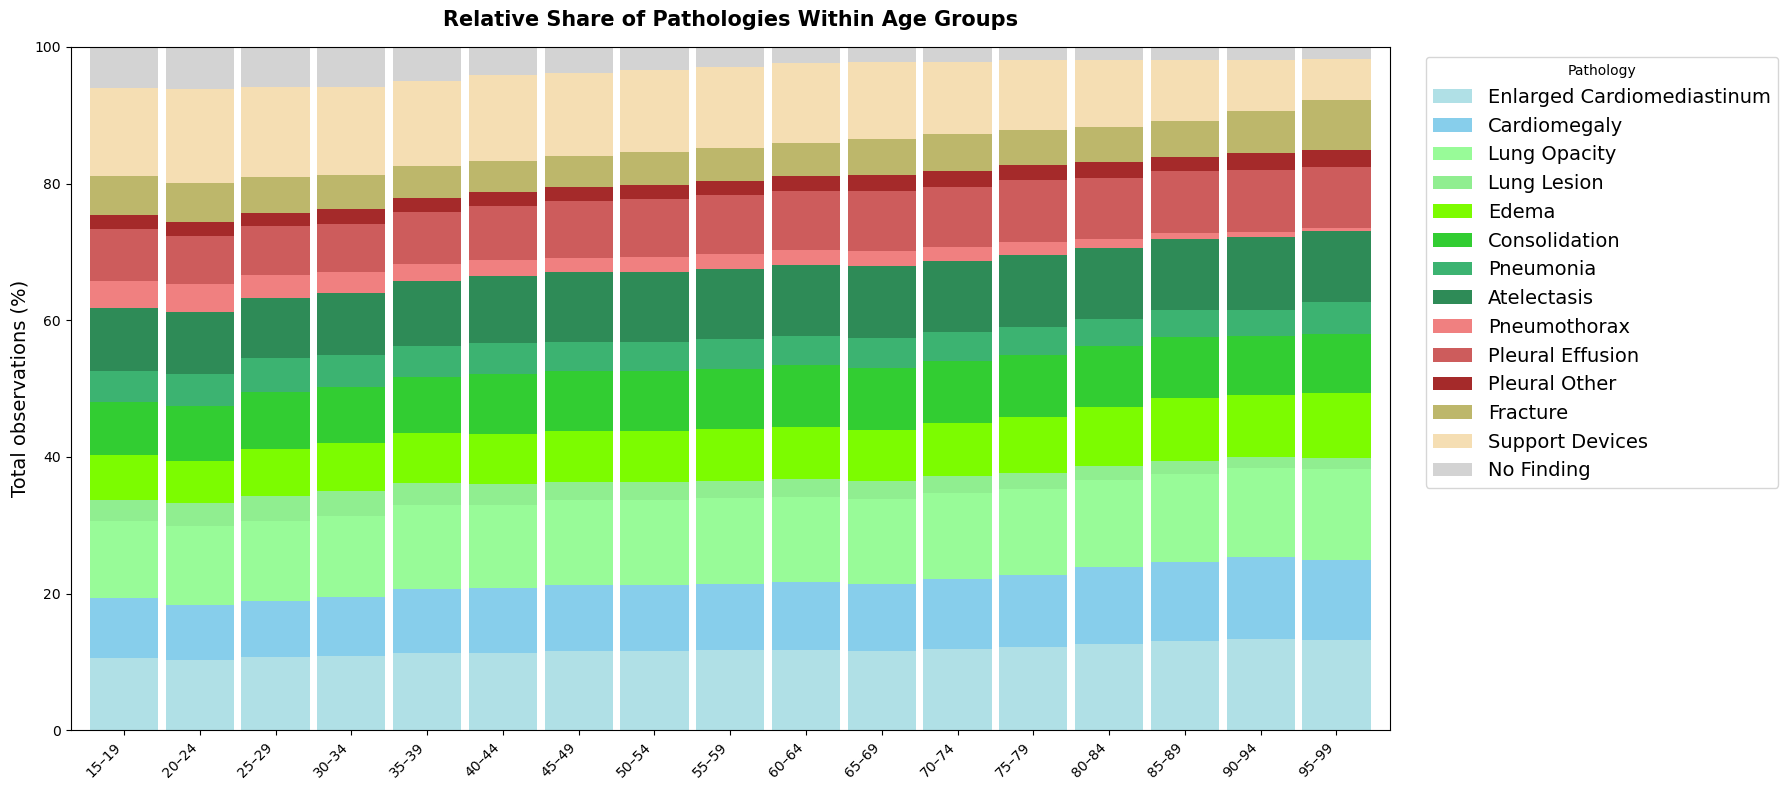

In [17]:
# Relative Share of Pathologies Within Age Groups, 100% stacked bar chart

plot_pathologies_share_agegroup(df_pct, 'pathologies_share_agegroup')


In [18]:
df_calc = train_data.groupby('Sex')[labels].sum()
df_calc

,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,No Finding
Sex,,,,,,,,,,,,,,
Female,58387.0,49357.0,61463.0,12418.0,39089.0,43940.0,21342.0,49985.0,9673.0,41980.0,10447.0,25187.0,53639.0,14538.0
Male,85406.0,72404.0,89870.0,18588.0,55166.0,63183.0,30819.0,73813.0,15664.0,61568.0,15836.0,36394.0,82261.0,20962.0


In [19]:
# convert counts to percentages per Sex
df_sex_pct = df_calc.div(df_calc.sum(axis=1), axis=0) * 100
df_sex_pct

,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,No Finding
Sex,,,,,,,,,,,,,,
Female,11.880678,10.043240,12.506588,2.526834,7.953891,8.940980,4.342704,10.171026,1.968277,8.542156,2.125772,5.125090,10.914548,2.958215
Male,11.830167,10.029172,12.448506,2.574751,7.641419,8.751908,4.268950,10.224342,2.169727,8.528203,2.193552,5.041181,11.394532,2.903590


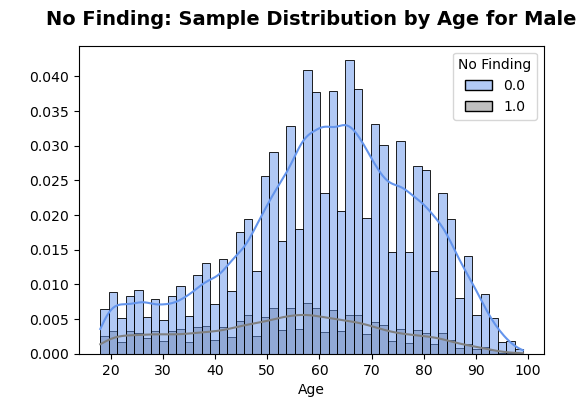

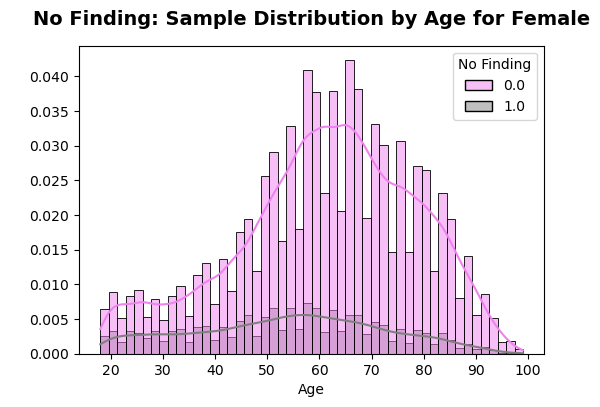

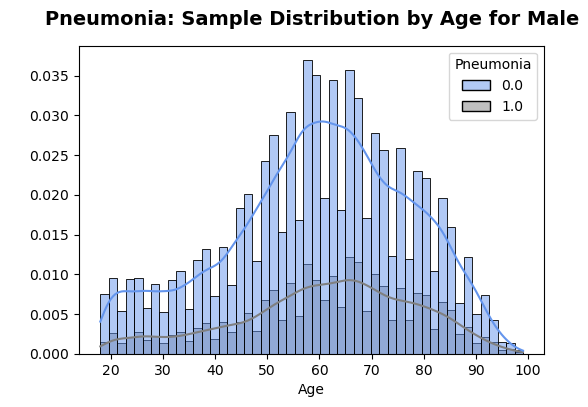

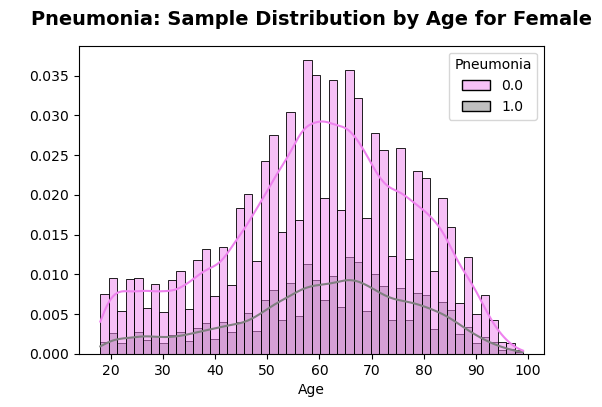

In [20]:
# histograms by Age

# this is a boolean filter
boolean_filter = train_data['Sex'] == 'Male'
male_df = train_data.loc[boolean_filter].reset_index(drop=True)

# this is a boolean filter
boolean_filter = train_data['Sex'] == 'Female'
female_df = train_data.loc[boolean_filter].reset_index(drop=True)

histogram_by_age(male_df, sex = 'Male', hue = "No Finding" ,file_name ='histogram_by_age_NoFinding_M')

histogram_by_age(male_df, sex = 'Female', hue = "No Finding" ,file_name ='histogram_by_age_NoFinding_F')

histogram_by_age(male_df, sex = 'Male', hue = "Pneumonia" ,file_name ='histogram_by_age_Pneumonia_M')

histogram_by_age(male_df, sex = 'Female', hue = "Pneumonia" ,file_name ='histogram_by_age_Pneumonia_F')



In [21]:
# Due to resource limitations, further analysis was focused on five pathologies: Cardiomegaly, Pneumonia, Pleural Effusion, Fracture, and No Finding.
df_changed = df_observation_reduction(train_data)

df_changed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191211 entries, 0 to 191210
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   Path              191211 non-null  object  
 1   Sex               191211 non-null  object  
 2   Age               191211 non-null  int64   
 3   Frontal/Lateral   191211 non-null  object  
 4   AP/PA             163436 non-null  object  
 5   Cardiomegaly      191211 non-null  float64 
 6   Pneumonia         191211 non-null  float64 
 7   Pleural Effusion  191211 non-null  float64 
 8   Fracture          191211 non-null  float64 
 9   No Finding        191211 non-null  float64 
 10  age_group         191211 non-null  category
dtypes: category(1), float64(5), int64(1), object(4)
memory usage: 14.8+ MB


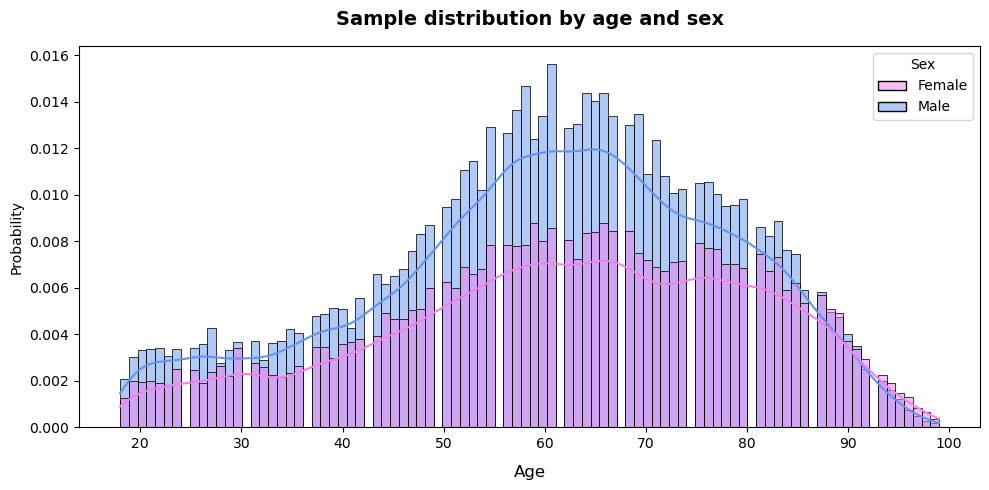

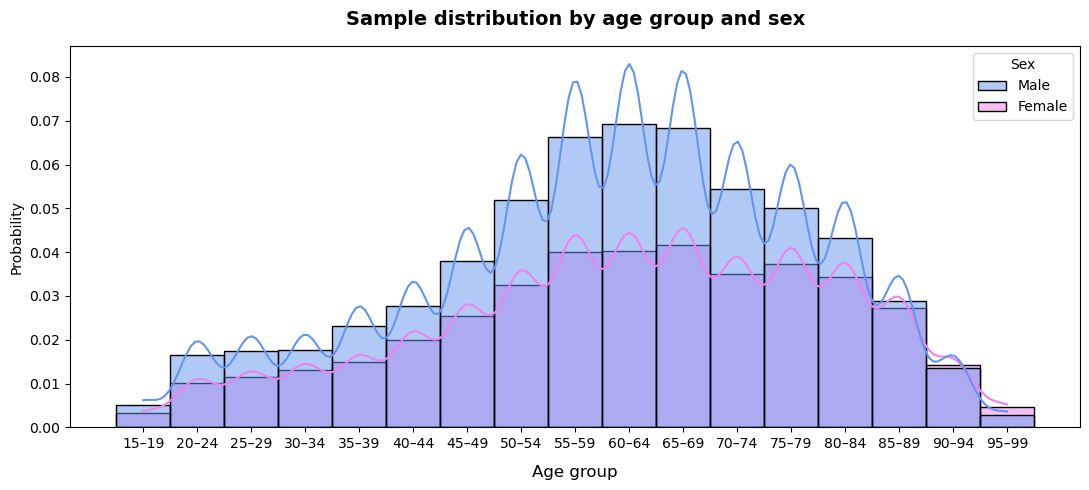

In [22]:
plot_age_distr_by_sex(df_changed)

plot_agegroup_distr_by_sex(df_changed, 'agegroup_distr_by_sex_changed')

In [23]:
df_calc_changed = df_changed.groupby('Sex')[labels_small].sum()
df_calc_changed

,Cardiomegaly,Pneumonia,Pleural Effusion,Fracture,No Finding
Sex,,,,,
Female,49357.0,21342.0,41980.0,25187.0,14538.0
Male,72404.0,30819.0,61568.0,36394.0,20962.0


In [24]:
# Dataset fairness audit before model training

sex_dataset_audit = data_representation_fairness(df_changed,'Sex')
# print('Data representation fairness for Sex attribute')
# print(sex_dataset_audit)

age_dataset_audit = data_representation_fairness(df_changed,'age_group')
# print('Data representation fairness for Age group attribute')
# print(age_dataset_audit)

sex_label_audit = risk_ratio_multilabel(df_changed, 'Sex', labels_small)
# print('Label distribution fairness for Sex attribute')
# print(sex_label_audit)

age_label_audit = risk_ratio_multilabel(df_changed, 'age_group', labels_small)
# print('Label distribution fairness for Age group attribute')
# print(age_label_audit)

intersectional_dataset_audit = coverage_gap_intersectional(df_changed, 'age_group', 'Sex')
# print('Intersectional coverage for the combination of sensitive attributes')
# print(intersectional_dataset_audit)

intersectional_risk_ratio_audit = risk_ratio_multilabel_intersectional_group(df_changed, 'age_group', 'Sex', labels_small)
# print('Label distribution fairness for the combination of sensitive attributes')
# print(intersectional_risk_ratio_audit)

js_divergence_sex = js_divergence_by_group(df_changed, 'Sex', labels_small)
js_divergence_age = js_divergence_by_group(df_changed, 'age_group', labels_small)

js_label_divergence_sex = js_divergence_by_label_and_group(df_changed, 'Sex', labels_small)
js_label_divergence_age = js_divergence_by_label_and_group(df_changed, 'age_group', labels_small)


output_path = results_path+"dataset_fairness_audit.xlsx"

with pd.ExcelWriter(output_path, engine="xlsxwriter") as writer:
    sex_dataset_audit.to_excel(writer, sheet_name="Sex_Representation", index=False)
    age_dataset_audit.to_excel(writer, sheet_name="Age_Representation", index=False)
    sex_label_audit.to_excel(writer, sheet_name="Sex_risk_ratio", index=False)
    age_label_audit.to_excel(writer, sheet_name="Age_risk_ratio", index=False)
    intersectional_dataset_audit.to_excel(writer, sheet_name="Coverage_GAP", index=False)
    intersectional_risk_ratio_audit.to_excel(writer, sheet_name="Intersectional_risk_ratio", index=False)
    js_divergence_sex.to_excel(writer, sheet_name="Sex_JS", index=False)
    js_divergence_age.to_excel(writer, sheet_name="Age_JS", index=False)
    js_label_divergence_sex.to_excel(writer, sheet_name="Sex_JS_label", index=False)
    js_label_divergence_age.to_excel(writer, sheet_name="Age_JS_label", index=False)

In [25]:
# Step 3. Data resampling, Males undersampling.
# 50% Male / 50% Female in the whole dataframe, exactly
# For each disease column 50% Male / 50% Female, approximately

# balanced_df = build_balanced_df(df_changed, labels_small, random_state=42)

# balanced_df.to_csv(results_path + "train_balanced.csv", index=False)

# balanced_df = pd.read_csv(results_path+"train_balanced.csv")
balanced_df = pd.read_csv(balanced_train_file_path)

In [26]:
# Check for duplicated rows
duplicateRowsDF = balanced_df[balanced_df.duplicated()]
print(duplicateRowsDF)

balanced_df_calc = balanced_df.groupby('Sex')[labels_small].sum()
balanced_df_calc

Empty DataFrame
Columns: [Path_old, Sex, Age, Frontal/Lateral, AP/PA, Cardiomegaly, Pneumonia, Pleural Effusion, Fracture, No Finding, age_group, Path]
Index: []


,Cardiomegaly,Pneumonia,Pleural Effusion,Fracture,No Finding
Sex,,,,,
Female,49459,21194,41996,25046,14447
Male,49279,21034,41987,24900,14419


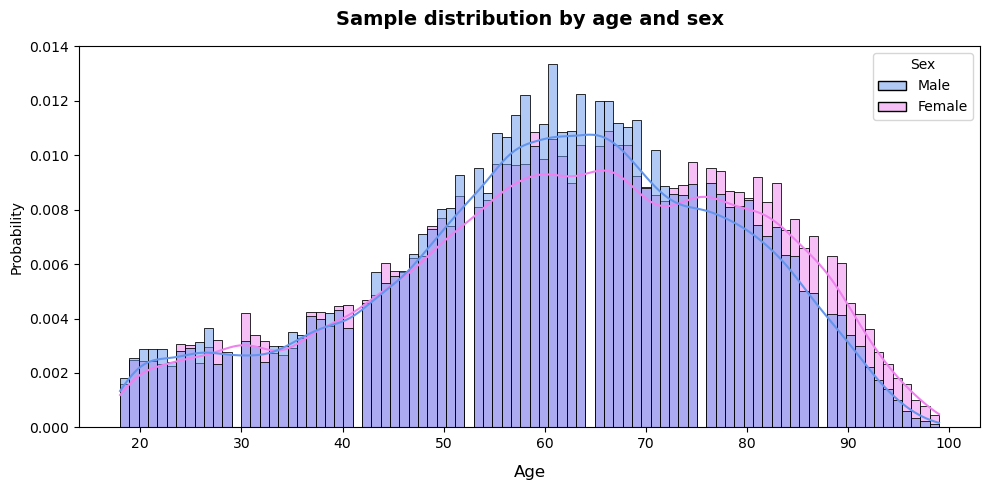

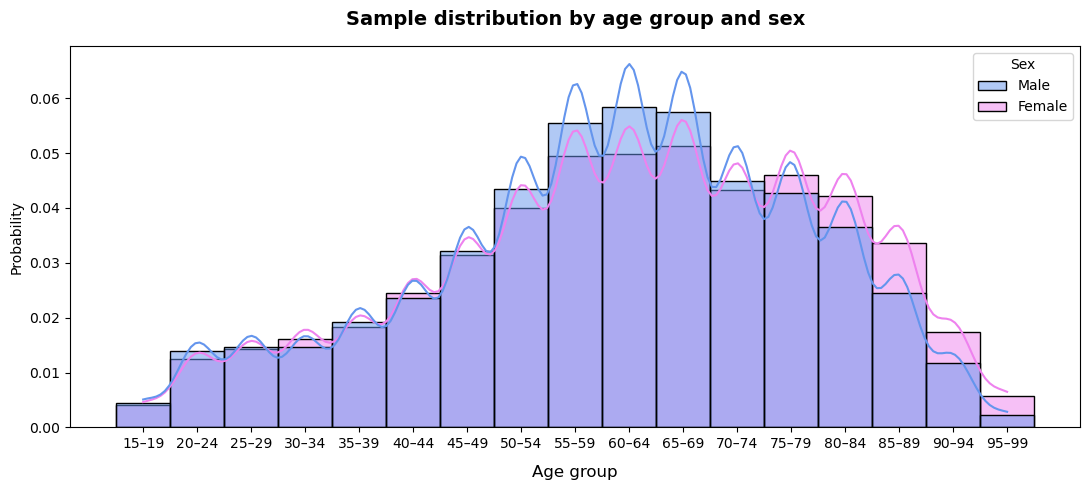

In [27]:
plot_age_distr_by_sex(balanced_df)

plot_agegroup_distr_by_sex(balanced_df, 'agegroup_distr_by_sex_balanced')

In [28]:
# # # Total file size

# from pathlib import Path

# sizes = []
# for p in balanced_df["Path_new"]:
#     full_path = p
#     # full_path = "D:/chexpertchestxrays/"+p
#     try:
#         sizes.append(Path(full_path).stat().st_size)
#     except FileNotFoundError:
#         sizes.append(0)

# balanced_df["file_size_bytes"] = sizes

# total_size_bytes = balanced_df["file_size_bytes"].sum()

# total_size_MB = total_size_bytes / (1024 ** 2)
# total_size_GB = total_size_bytes / (1024 ** 3)

# print(f"Total size: {total_size_MB:.2f} MB")
# print(f"Total size: {total_size_GB:.2f} GB")

# # Total size: 8508.13 MB
# # Total size: 8.31 GB

In [29]:
## Resizes images to 512×512

# from pathlib import Path
# from PIL import Image

# # target resolution
# TARGET_SIZE = (512, 512)

# def resize_and_copy_image(src_path: str) -> str:
#     src_path = "D:/chexpertchestxrays/"+src_path
#     src_path = Path(src_path)
   
#     # create new path: train → train_small
#     dst_path = Path(
#         str(src_path).replace("train", "train_small", 1)
#     )

#     # create parent directories if needed
#     dst_path.parent.mkdir(parents=True, exist_ok=True)

#     # load, resize, save
#     with Image.open(src_path) as img:
#         img = img.convert("RGB")  # safe for all models
#         img = img.resize(TARGET_SIZE, Image.LANCZOS)
#         img.save(dst_path, format="JPEG", quality=90, subsampling=0)
    
#     dst_path = str(dst_path)
#     dst_path = dst_path.replace("D:/chexpertchestxrays/", "", 1)
    
#     return dst_path

# balanced_df["Path_new"] = balanced_df["Path"].apply(resize_and_copy_image)

# # balanced_df["Path_new"] = balanced_df["Path"].progress_apply(resize_and_copy_image)

# balanced_df

In [30]:
# balanced_df.to_csv(results_path + "train_balanced_small.csv", index=False)

In [31]:
# Dataset fairness audit before model training
# After resampling

sex_dataset_audit = data_representation_fairness(balanced_df,'Sex')
# print('Data representation fairness for Sex attribute')
# print(sex_dataset_audit)

age_dataset_audit = data_representation_fairness(balanced_df,'age_group')
# print('Data representation fairness for Age group attribute')
# print(age_dataset_audit)

sex_label_audit = risk_ratio_multilabel(balanced_df, 'Sex', labels_small)
# print('Label distribution fairness for Sex attribute')
# print(sex_label_audit)

age_label_audit = risk_ratio_multilabel(balanced_df, 'age_group', labels_small)
# print('Label distribution fairness for Age group attribute')
# print(age_label_audit)

intersectional_dataset_audit = coverage_gap_intersectional(balanced_df, 'age_group', 'Sex')
# print('Intersectional coverage for the combination of sensitive attributes')
# print(intersectional_dataset_audit)

intersectional_risk_ratio_audit = risk_ratio_multilabel_intersectional_group(balanced_df, 'age_group', 'Sex', labels_small)
# print('Label distribution fairness for the combination of sensitive attributes')
# print(intersectional_risk_ratio_audit)

js_divergence_sex = js_divergence_by_group(balanced_df, 'Sex', labels_small)
js_divergence_age = js_divergence_by_group(balanced_df, 'age_group', labels_small)

js_label_divergence_sex = js_divergence_by_label_and_group(balanced_df, 'Sex', labels_small)
js_label_divergence_age = js_divergence_by_label_and_group(balanced_df, 'age_group', labels_small)

output_path = results_path+"resampled_dataset_fairness_audit.xlsx"

with pd.ExcelWriter(output_path, engine="xlsxwriter") as writer:
    sex_dataset_audit.to_excel(writer, sheet_name="Sex_Representation", index=False)
    age_dataset_audit.to_excel(writer, sheet_name="Age_Representation", index=False)
    sex_label_audit.to_excel(writer, sheet_name="Sex_risk_ratio", index=False)
    age_label_audit.to_excel(writer, sheet_name="Age_risk_ratio", index=False)
    intersectional_dataset_audit.to_excel(writer, sheet_name="Coverage_GAP", index=False)
    intersectional_risk_ratio_audit.to_excel(writer, sheet_name="Intersectional_risk_ratio", index=False)
    js_divergence_sex.to_excel(writer, sheet_name="Sex_JS", index=False)
    js_divergence_age.to_excel(writer, sheet_name="Age_JS", index=False)
    js_label_divergence_sex.to_excel(writer, sheet_name="Sex_JS_label", index=False)
    js_label_divergence_age.to_excel(writer, sheet_name="Age_JS_label", index=False)


In [32]:
test_data = pd.read_csv(test_file_path)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234 entries, 0 to 233
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Path                        234 non-null    object 
 1   Sex                         234 non-null    object 
 2   Age                         234 non-null    int64  
 3   Frontal/Lateral             234 non-null    object 
 4   AP/PA                       202 non-null    object 
 5   No Finding                  234 non-null    float64
 6   Enlarged Cardiomediastinum  234 non-null    float64
 7   Cardiomegaly                234 non-null    float64
 8   Lung Opacity                234 non-null    float64
 9   Lung Lesion                 234 non-null    float64
 10  Edema                       234 non-null    float64
 11  Consolidation               234 non-null    float64
 12  Pneumonia                   234 non-null    float64
 13  Atelectasis                 234 non

In [33]:
df_calc = test_data.groupby('Sex')[['Sex']].count()
print(df_calc)

df_calc = test_data.groupby('Age')[['Age']].count()
print(df_calc)

        Sex
Sex        
Female  106
Male    128
     Age
Age     
18     2
19     2
21     2
22     2
23     5
..   ...
85     7
86     1
87     3
88     2
90    11

[64 rows x 1 columns]


In [34]:
test_data = df_age_disaggregation(test_data)

In [35]:
df_calc = test_data.groupby('age_group')[labels_small].sum()

column_totals = (
    df_calc
    .sum()
    .reset_index()
    .rename(columns={"index": "pathology", 0: "total"})
)

total_observations = column_totals['total'].sum()
column_totals['percent'] = column_totals['total']/total_observations*100

column_totals = column_totals.sort_values(by=['total'], ascending = False)
print(column_totals)
print('Total observations', total_observations)

          pathology  total    percent
0      Cardiomegaly   68.0  37.569061
2  Pleural Effusion   67.0  37.016575
4        No Finding   38.0  20.994475
1         Pneumonia    8.0   4.419890
3          Fracture    0.0   0.000000
Total observations 181.0


In [37]:
df_calc = test_data.groupby('age_group')[labels].sum()

column_totals = (
    df_calc
    .sum()
    .reset_index()
    .rename(columns={"index": "pathology", 0: "total"})
)

total_observations = column_totals['total'].sum()
column_totals['percent'] = column_totals['total']/total_observations*100

column_totals = column_totals.sort_values(by=['total'], ascending = False)
print(column_totals)
print('Total observations', total_observations)

                     pathology  total    percent
2                 Lung Opacity  126.0  18.234443
0   Enlarged Cardiomediastinum  109.0  15.774240
12             Support Devices  107.0  15.484805
7                  Atelectasis   80.0  11.577424
1                 Cardiomegaly   68.0   9.840810
9             Pleural Effusion   67.0   9.696093
4                        Edema   45.0   6.512301
13                  No Finding   38.0   5.499276
5                Consolidation   33.0   4.775687
6                    Pneumonia    8.0   1.157742
8                 Pneumothorax    8.0   1.157742
3                  Lung Lesion    1.0   0.144718
10               Pleural Other    1.0   0.144718
11                    Fracture    0.0   0.000000
Total observations 691.0


In [39]:
# Dataset fairness audit for validation set

sex_dataset_audit = data_representation_fairness(test_data,'Sex')
print('Data representation fairness for Sex attribute')
print(sex_dataset_audit)


sex_label_audit = risk_ratio_multilabel(test_data, 'Sex', labels_small)
print('Label distribution fairness for Sex attribute')
print(sex_label_audit)


Data representation fairness for Sex attribute
      Sex  Samples  Representation rate, %  Disparate impact ratio  \
0  Female      106                 45.2991                  0.8281   
1    Male      128                 54.7009                  1.0000   

  DI interpretation  Generalised DI ratio            GDI interpretation  
0        Acceptable                 0.906  Moderate Underrepresentation  
1         Reference                 1.094   Moderate Overrepresentation  
Label distribution fairness for Sex attribute
              Label Attribute  Prevalence  Risk ratio Reference group  \
0      Cardiomegaly    Female      0.2925        1.00          Female   
1      Cardiomegaly      Male      0.2891        0.99          Female   
2         Pneumonia    Female      0.0377        1.00          Female   
3         Pneumonia      Male      0.0312        0.83          Female   
4  Pleural Effusion    Female      0.3868        1.00          Female   
5  Pleural Effusion      Male      0